In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from IPython.display import display
import stumpy
import numpy as np
from sklearn.decomposition import PCA, FactorAnalysis, KernelPCA

np.set_printoptions(suppress=True)

jan31 = pd.read_csv("data/Jan_31_Data/31JAN2022_2Pto4P_pivoted.csv")
jan31.time = pd.to_datetime(jan31.time, format='%Y-%m-%dT%H:%M:%S.%f')
jan31 = jan31.set_index('time')

print(jan31.columns)
jan31 = jan31.iloc[:, :13] # Keep only continuous bond FFT values (dropping overall RMS)
jan31 = jan31.drop(columns=['Bonding Roll Command Velocity']) # Bonding Roll Command Velocity doesn't change ever


jan31_by_second_df = jan31.groupby(by=[jan31.index.year, jan31.index.month, jan31.index.day, jan31.index.hour, jan31.index.minute, jan31.index.second]).agg('mean')
jan31_by_second_df.index = pd.to_datetime(jan31_by_second_df.index.get_level_values(0).astype(str) + '-' +
               jan31_by_second_df.index.get_level_values(1).astype(str) + '-' +
               jan31_by_second_df.index.get_level_values(2).astype(str) + 'T' +
               jan31_by_second_df.index.get_level_values(3).astype(str) + ':' +
               jan31_by_second_df.index.get_level_values(4).astype(str) + ':' +
               jan31_by_second_df.index.get_level_values(5).astype(str),
               format='%Y-%m-%dT%H:%M:%S')

# max normalization
jan31_by_second_df = jan31_by_second_df / jan31_by_second_df.max(axis=0)

display(jan31_by_second_df.head())


Index(['Bonding Roll Actual Velocity', 'Bonding Roll Command Velocity',
       'Bonding Roll Position Error', 'Bonding Roll Torque',
       'Continuous Bond FFT Band 0', 'Continuous Bond FFT Band 1',
       'Continuous Bond FFT Band 2', 'Continuous Bond FFT Band 3',
       'Continuous Bond FFT Band 4', 'Continuous Bond FFT Band 5',
       'Continuous Bond FFT Band 6', 'Continuous Bond FFT Band 7',
       'Continuous Bond Vibration', 'Tackdown Bond Vibration',
       'Tackdown FFT Band 0', 'Tackdown FFT Band 1', 'Tackdown FFT Band 2',
       'Tackdown FFT Band 3', 'Tackdown FFT Band 4', 'Tackdown FFT Band 5',
       'Tackdown FFT Band 6', 'Tackdown FFT Band 7'],
      dtype='object')


,Bonding Roll Actual Velocity,Bonding Roll Position Error,Bonding Roll Torque,Continuous Bond FFT Band 0,Continuous Bond FFT Band 1,Continuous Bond FFT Band 2,Continuous Bond FFT Band 3,Continuous Bond FFT Band 4,Continuous Bond FFT Band 5,Continuous Bond FFT Band 6,Continuous Bond FFT Band 7,Continuous Bond Vibration
time,,,,,,,,,,,,
2022-01-31 14:00:00,0.999086,-0.471505,0.885837,0.539246,0.585828,0.618613,0.577821,0.430337,0.495480,0.434372,0.458486,0.763183
2022-01-31 14:00:01,0.999111,0.075326,0.901784,0.642314,0.673054,0.709895,0.593260,0.384868,0.472206,0.347975,0.437478,0.763841
2022-01-31 14:00:02,0.999053,-0.325293,0.885350,0.571647,0.572843,0.534485,0.582538,0.441382,0.575491,0.446799,0.506356,0.741333
2022-01-31 14:00:03,0.999217,0.073200,0.853649,0.513901,0.469862,0.432157,0.590948,0.577467,0.577802,0.318383,0.423117,0.737164
2022-01-31 14:00:04,0.999156,-0.165433,0.892984,0.568664,0.597349,0.557894,0.504563,0.406916,0.457805,0.443360,0.415331,0.724301


In [52]:
m=60
mps, indices = stumpy.mstump(jan31_by_second_df, m)


In [53]:
motifs_idx = np.argsort(mps, axis=1)[:, 0]

In [54]:
nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

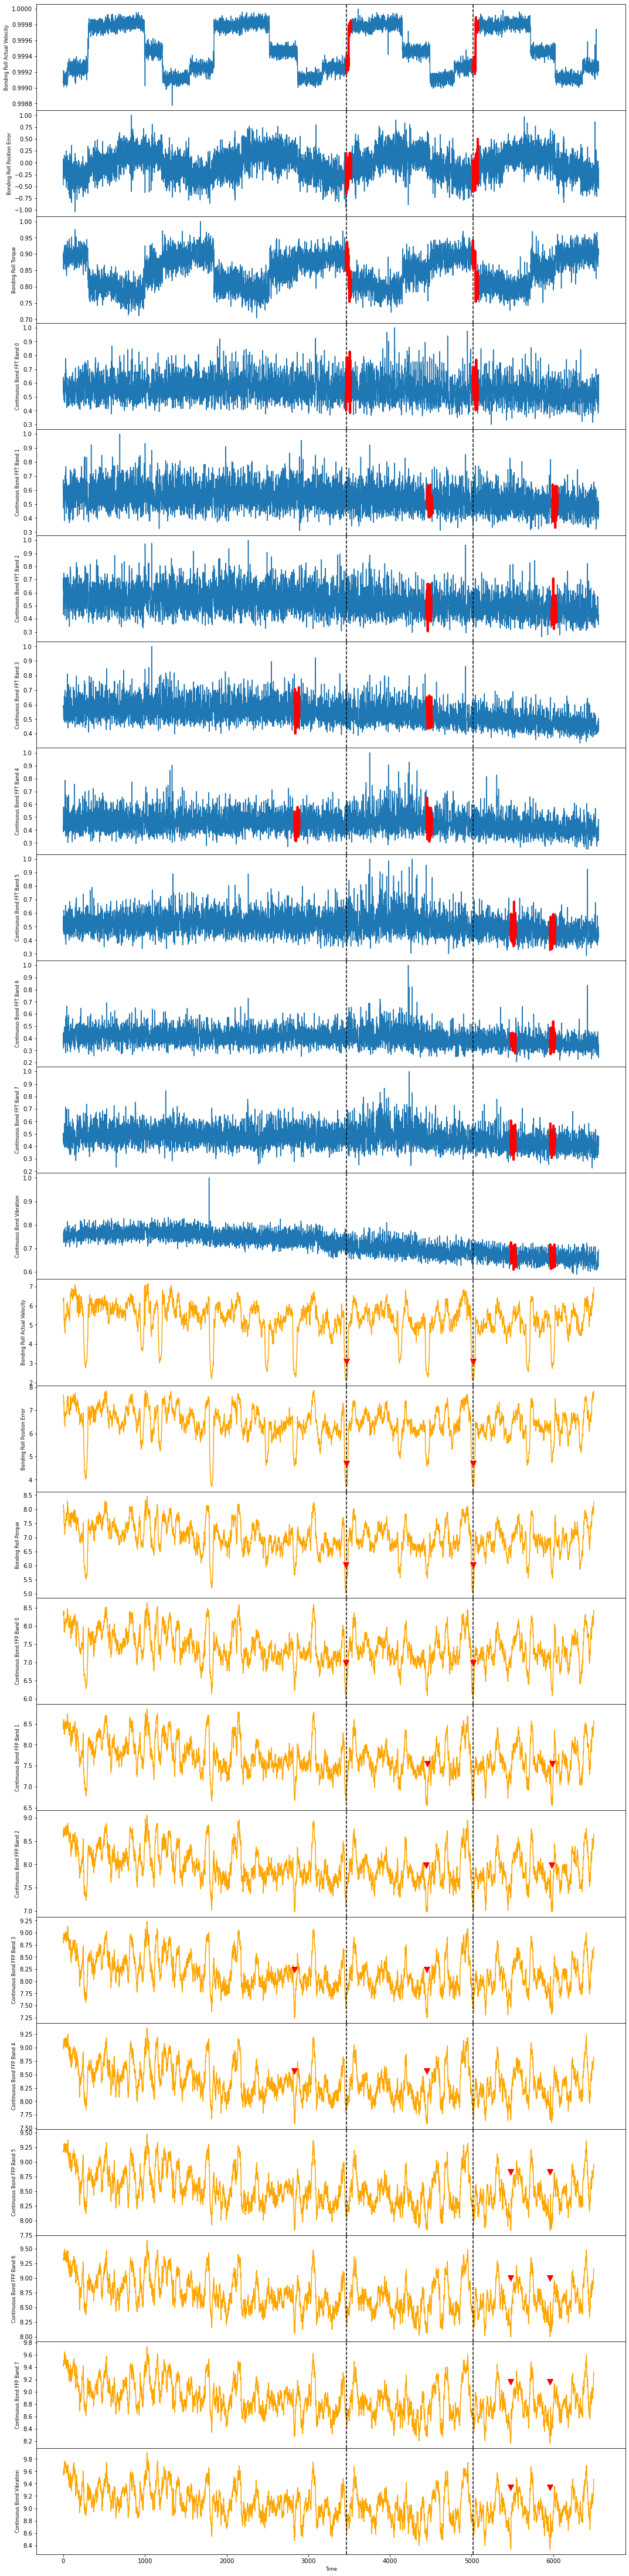

In [55]:
fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(18,80))

for k, dim_name in enumerate(jan31_by_second_df.columns):
    axs[k].set_ylabel(dim_name, fontsize='8')
    axs[k].plot(np.arange(jan31_by_second_df.shape[0]), jan31_by_second_df[dim_name])
    axs[k].set_xlabel('Time', fontsize ='8')

    axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'P'), fontsize='8')
    axs[k + mps.shape[0]].plot(mps[k], c='orange')
    axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='8')

    axs[k].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k].axvline(x=nn_idx[1], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=motifs_idx[1], linestyle="dashed", c='black')
    axs[k + mps.shape[0]].axvline(x=nn_idx[1], linestyle="dashed", c='black')

    if dim_name != 'T3':
        axs[k].plot(range(motifs_idx[k], motifs_idx[k] + m), jan31_by_second_df[dim_name].iloc[motifs_idx[k] : motifs_idx[k] + m], c='red', linewidth=4)
        axs[k].plot(range(nn_idx[k], nn_idx[k] + m), jan31_by_second_df[dim_name].iloc[nn_idx[k] : nn_idx[k] + m], c='red', linewidth=4)
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='red')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='red')
    else:
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='black')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='black')

plt.show()